In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1

2023-05-06 16:44:10.752270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-05-06 16:44:12.646283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:44:12.678849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:44:12.679060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
learning_rate = 1e-3
num_dense_layers = 6
num_dense_nodes = 150
iterations = 10000
activation = 'tanh'
weights = 100

In [4]:
nx_train = 100
nx_test = 300

In [5]:
L = 2
n_max = 7

In [6]:
def pde(x, y):
    n = x[:, 1:2]
    k = (n * np.pi) / L
    E = 0.5 * (k ** 2)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return 0.5 * dy_xx + E * y

In [7]:
def psi(x):
    normalization_constant = np.sqrt(2.0 / L)
    n = x[:, 1:2]
    k = (n * np.pi) / L
    return normalization_constant * np.sin(k * (x[:, 0:1] + (L / 2)))

In [8]:
def x_boundary(x, on_boundary):
    if x[1].is_integer():
        return np.isclose(-L / 2, x[0]) or np.isclose(L / 2, x[0])
    return False

In [9]:
def get_collocation_points(n_max):
    points = []
    for n in range(1, n_max + 1):
        for k in range(n):
            x = (k * L) / n + L / (2 * n) - L / 2
            points.append((x, n))
            
        if n == 1:
            points.append((L / 4, n))
            points.append((-L / 4, n))
    
    return np.array(points)

In [10]:
domain = dde.geometry.Rectangle([-L / 2, 1], [L / 2, n_max])

In [12]:
collocation_points = get_collocation_points(n_max)
collocation_values = psi(collocation_points)

ic = dde.icbc.PointSetBC(collocation_points, collocation_values)

In [13]:
dirichlet_bc = dde.icbc.DirichletBC(domain, lambda x: 0, x_boundary)

In [14]:
data = dde.data.PDE(
    domain, 
    pde, 
    [ic, dirichlet_bc], 
    num_domain=nx_train ** 2, 
    num_boundary=n_max * 2,
    solution=psi, 
    num_test=nx_test ** 2
)

In [15]:
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], 
    activation, 
    'Glorot uniform')

In [16]:
model = dde.Model(data, net)

loss_weights = [1, weights, weights]
model.compile(
    'adam', 
    lr=learning_rate, 
    metrics=['l2 relative error'],
    loss_weights=loss_weights
)

Compiling model...
Building feed-forward neural network...
'build' took 0.111222 s



/home/piotr/repos/quant-chem-pinns/venv/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-05-06 16:49:16.125979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:49:16.126242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:49:16.126422: I tensorflow/compiler/x

'compile' took 1.596219 s



In [17]:
loss_history, train_state = model.train(iterations=iterations)

Initializing variables...


2023-05-06 16:49:27.165454: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...



2023-05-06 16:49:27.527188: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fe14c0051a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-06 16:49:27.527218: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce 940MX, Compute Capability 5.0
2023-05-06 16:49:27.536188: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-06 16:49:28.651426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-06 16:49:30.521304: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                        Test loss                         Test metric   
0         [8.63e+01, 9.85e+01, 7.41e+00]    [8.61e+01, 9.85e+01, 7.41e+00]    [1.03e+00]    
1000      [6.32e+00, 5.79e+01, 3.11e-02]    [6.34e+00, 5.79e+01, 3.11e-02]    [7.43e-01]    
2000      [7.72e-01, 3.42e-01, 5.63e-01]    [7.37e-01, 3.42e-01, 5.63e-01]    [6.87e-02]    
3000      [6.54e-01, 7.34e-02, 5.32e-01]    [6.40e-01, 7.34e-02, 5.32e-01]    [5.52e-02]    
4000      [1.70e-01, 1.90e-02, 3.61e-01]    [1.65e-01, 1.90e-02, 3.61e-01]    [4.63e-02]    
5000      [7.72e-02, 5.36e-03, 6.72e-02]    [7.46e-02, 5.36e-03, 6.72e-02]    [2.21e-02]    
6000      [7.47e-02, 3.13e-03, 1.25e-01]    [7.36e-02, 3.13e-03, 1.25e-01]    [2.76e-02]    
7000      [2.27e-01, 1.51e-02, 1.47e-01]    [2.27e-01, 1.51e-02, 1.47e-01]    [3.40e-02]    
8000      [8.53e-02, 6.75e-03, 1.20e-01]    [8.45e-02, 6.75e-03, 1.20e-01]    [3.34e-02]    
9000      [1.07e+00, 7.96e-02, 3.20e-01]    [1.07e+00, 7.96e-02, 3.20e

Saving loss history to /home/piotr/repos/quant-chem-pinns/potential-well/2d/rectangle/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/potential-well/2d/rectangle/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/potential-well/2d/rectangle/test.dat ...


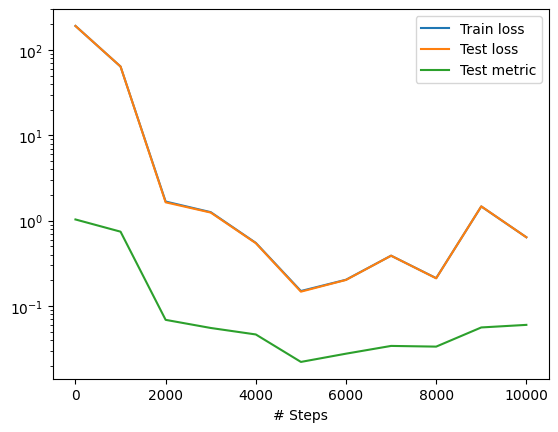

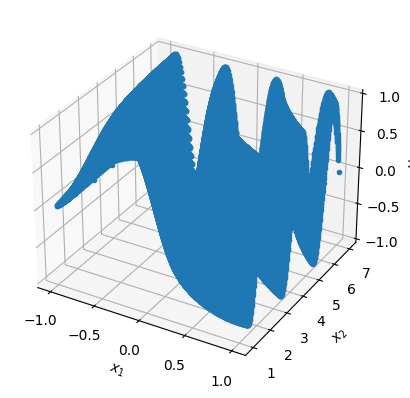

In [18]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [26]:
def predict_for_n(points):
    prediction = model.predict(points)
    return np.array(prediction)

In [27]:
def plot_results_for_n(n, num_points=10):
    x = np.linspace(-L / 2, L / 2, num=num_points)
    points = np.array([[i, n] for i in x])
    predictions = predict_for_n(points)
    true_values = psi(points)
    
    fig, ax = plt.subplots()
    ax.plot(x, predictions, 'bo', label='predicted')
    ax.plot(x, true_values, '--', label='true')
    fig.legend()

In [28]:
def psi_2d_rectangle(x, nx, ny):
    x_values = x[:, 0:1]
    y_values = x[:, 1:2]
    
    x_input = np.array([[i[0], nx] for i in x_values])
    y_input = np.array([[i[0], ny] for i in y_values])
    
    x_component = psi(x_input)
    y_component = psi(y_input)
    
    return x_component * y_component  

In [29]:
def psi_2d_model(x, nx, ny):
    x_values = x[:, 0:1]
    y_values = x[:, 1:2]
    
    x_input = np.array([[i[0], nx] for i in x_values])
    y_input = np.array([[i[0], ny] for i in y_values])
    
    x_component = model.predict(x_input)
    y_component = model.predict(y_input)
    
    return x_component * y_component

In [30]:
def diff_function(x, nx, ny):    
    model_value = psi_2d_model(x, nx, ny)
    true_value = psi_2d_rectangle(x, nx, ny)
    return model_value - true_value

In [31]:
def plot_2d_map(plotted_function, nx, ny, grid_dist=0.01):
    x_ax = np.arange(-L / 2, L / 2, grid_dist)
    y_ax = np.arange(-L / 2, L / 2, grid_dist)
    grid_x, grid_y = np.meshgrid(x_ax, y_ax)
    
    diff_list = []
    for a, b in zip(grid_x, grid_y):
        pair_list = []
        for x, y in zip(a, b):
            pair_list.append([x, y])
        pairs = np.array(pair_list)
        diff_list.append(np.squeeze(plotted_function(pairs, nx, ny)))

    diff_list = np.array(diff_list)
    
    im = plt.imshow(diff_list, cmap=plt.cm.RdBu)
    plt.colorbar(im)

    plt.show()

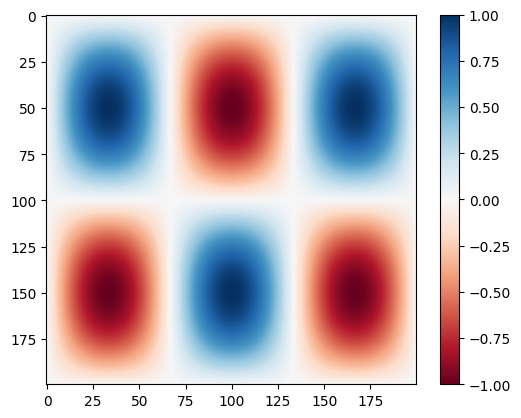

In [32]:
plot_2d_map(psi_2d_rectangle, 3, 2)

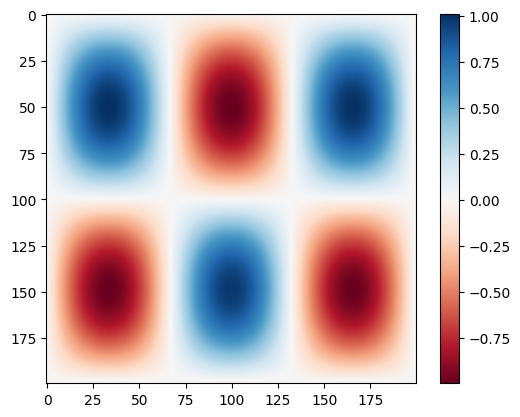

In [33]:
plot_2d_map(psi_2d_model, 3, 2)

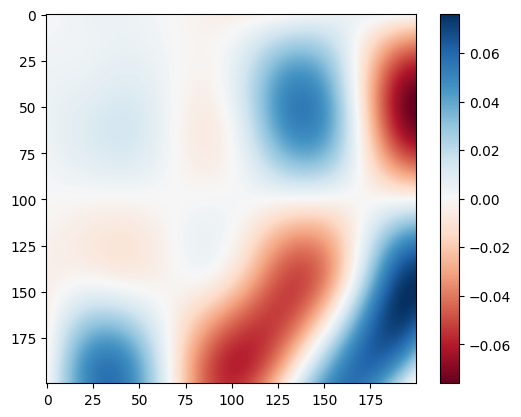

In [34]:
plot_2d_map(diff_function, 3, 2)